In [1]:
from os import path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import utils

data_directory = "/Users/nepal/Documents/synapthesis/synData6July"
lotti_fn = "export_lotti_veneto_2016_2018_giulio_v2.csv"
vincitori_fn = "export_vincitori_veneto_2016_2018_giulio_v2.csv"
procedura_fn = "/Users/nepal/Documents/synapthesis/tipi_procedure.txt"

lotti = pd.read_csv(path.join(data_directory, lotti_fn), index_col="id_lotto")
vincitori = pd.read_csv(path.join(data_directory, vincitori_fn), index_col="id_lotto")
tipi_procedura = pd.read_csv(procedura_fn, index_col="id_scelta_contraente")

lotti.data_inizio = pd.to_datetime(lotti.data_inizio, yearfirst=True)
lotti.data_fine = pd.to_datetime(lotti.data_fine, yearfirst=True)
lotti.data_inferita = pd.to_datetime(lotti.data_inferita, yearfirst=True)

In [2]:
utils.print_df_measures(lotti)

SHAPE: (1382247, 15)

DTYPES
id_pa                            int64
oggetto                         object
id_scelta_contraente           float64
importo                        float64
importo_base_asta              float64
importo_liquidato              float64
data_inizio             datetime64[ns]
data_fine               datetime64[ns]
data_inferita           datetime64[ns]
id_lsf                         float64
id_mod_realizz                 float64
id_forma_giuridica               int64
uber_forma_giuridica            object
cpv                            float64
cpv_vero                        object
dtype: object

COMPLETENESS percentages (100 means no NaNs)
id_pa                   100.000000
oggetto                  99.987122
id_scelta_contraente     99.903273
importo                  99.603038
importo_base_asta         1.890834
importo_liquidato        69.557973
data_inizio              68.549036
data_fine                65.455161
data_inferita            99.966070
id_lsf     

# Data preparation

## lotti dataframe

In [3]:
lotti = utils.replace_missing_value(lotti, "importo", "importo_base_asta")

importo values to substitute:           0.0012%


In [4]:
lotti = utils.replace_missing_value(lotti, "data_inizio", "data_inferita")

data_inizio values to substitute:           0.3145%


In [5]:
# drop non relevante table attributes
lotti = lotti.drop(columns=["oggetto", "importo_liquidato", "importo_base_asta", "data_inferita", "id_mod_realizz", "cpv_vero"])

per il momento scarto tutte le transazioni con almeno un missing value.
eventualmente quando non mi servirà la durata, tornerò indietro. 

In [6]:
lotti = lotti.dropna()

## cast to int64 cols now w/out np.nan

In [7]:
lotti.id_scelta_contraente = lotti.id_scelta_contraente.astype('int')
lotti.id_lsf = lotti.id_lsf.astype('int')
lotti.cpv = lotti.cpv.astype('int')
utils.print_df_measures(lotti)

SHAPE: (788453, 9)

DTYPES
id_pa                            int64
id_scelta_contraente             int64
importo                        float64
data_inizio             datetime64[ns]
data_fine               datetime64[ns]
id_lsf                           int64
id_forma_giuridica               int64
uber_forma_giuridica            object
cpv                              int64
dtype: object

COMPLETENESS percentages (100 means no NaNs)
id_pa                   100.0
id_scelta_contraente    100.0
importo                 100.0
data_inizio             100.0
data_fine               100.0
id_lsf                  100.0
id_forma_giuridica      100.0
uber_forma_giuridica    100.0
cpv                     100.0
dtype: float64


## vincitori dataframe


In [8]:
utils.print_df_measures(vincitori)

SHAPE: (917316, 3)

DTYPES
id_be                    int64
id_forma_giuridica       int64
uber_forma_giuridica    object
dtype: object

COMPLETENESS percentages (100 means no NaNs)
id_be                   100.000000
id_forma_giuridica      100.000000
uber_forma_giuridica     99.893603
dtype: float64


In [9]:
vincitori = vincitori.dropna()

## lotti merge vincitori merge tipi_procedura

In [21]:
df = lotti.merge(vincitori, on="id_lotto", how="inner", suffixes=("_acquirente", "_fornitore"))
df = df.join(tipi_procedura, on="id_scelta_contraente", how="left")

# feature extraction

In [23]:
# durata
df['durata'] = df.data_fine - df.data_inizio

In [24]:
# fatturato mediano annuo fornitori
supplier_rev = utils.compute_revenue_year(df, "id_be", "data_inizio").median(axis=1).rename("fatt_med_be")
df = df.merge(supplier_rev, on="id_be", how="left")

In [25]:
# erogato mediano annuo pa
buyer_rev = utils.compute_revenue_year(df, "id_pa", "data_inizio").median(axis=1).rename("erogato_med_pa")
df = df.merge(buyer_rev, on="id_pa", how="left")

In [26]:
utils.print_df_measures(df)

SHAPE: (755757, 17)

DTYPES
id_pa                                        int64
id_scelta_contraente                         int64
importo                                    float64
data_inizio                         datetime64[ns]
data_fine                           datetime64[ns]
id_lsf                                       int64
id_forma_giuridica_acquirente                int64
uber_forma_giuridica_acquirente             object
cpv                                          int64
id_be                                        int64
id_forma_giuridica_fornitore                 int64
uber_forma_giuridica_fornitore              object
procedura                                   object
tipo_procedura                              object
durata                             timedelta64[ns]
fatt_med_be                                float64
erogato_med_pa                             float64
dtype: object

COMPLETENESS percentages (100 means no NaNs)
id_pa                              100.0
id_s

# data visualization

In [27]:
# plot the log10 of the importo for visualization purposes

In [118]:
365 + 8*30

605

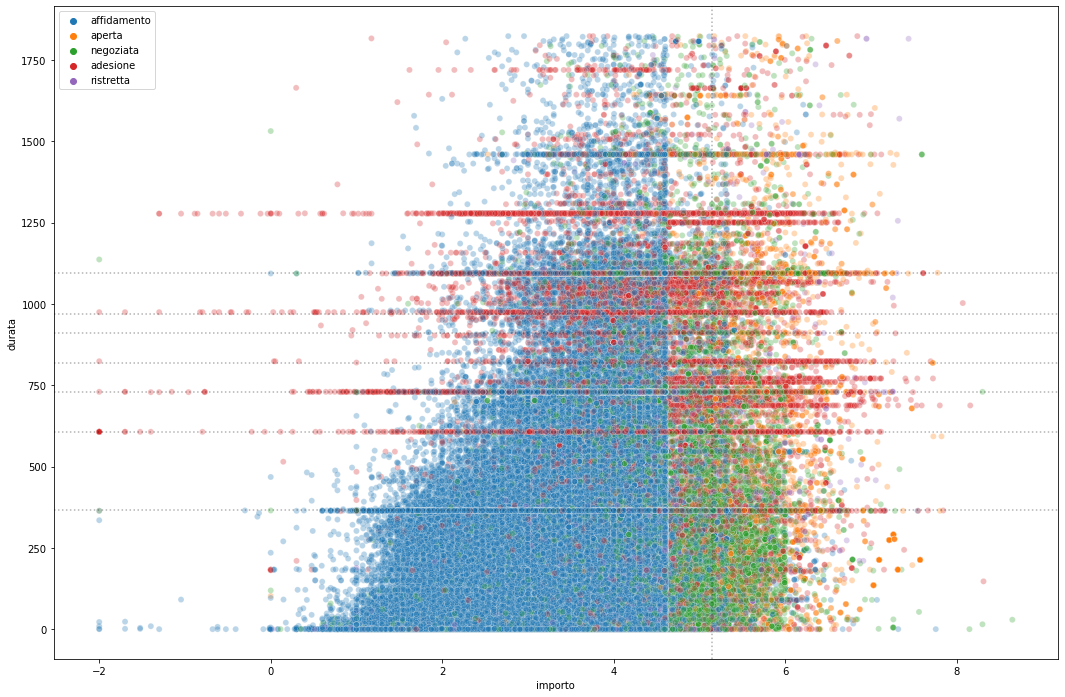

In [126]:
th = 365*5
plt.figure(figsize=(6*3, 4*3))
sns.scatterplot(
    x=np.log10(df[df.durata.dt.days < th].importo),
    y=df[df.durata.dt.days < th].durata.dt.days,
    alpha=.3, hue=df.tipo_procedura
)
plt.axvline(np.log10(14e4), color='black', linestyle="dotted", alpha=.3)
# plt.axvline(np.log10(10e4), color='black', linestyle="dotted", alpha=.3)
# plt.axvline(np.log10(4e4), color='black', linestyle="dotted", alpha=.3)
plt.axhline(365, color='black', linestyle="dotted", alpha=.3)
plt.axhline(365*2, color='black', linestyle="dotted", alpha=.3)
plt.axhline(365*3, color='black', linestyle="dotted", alpha=.3)
plt.axhline(365 + 30*8, color='black', linestyle="dotted", alpha=.3)
plt.axhline(365*2 + 30*3, color='black', linestyle="dotted", alpha=.3)
plt.axhline(365*2 + 30*8, color='black', linestyle="dotted", alpha=.3)
plt.axhline(365*2 + 30*6, color='black', linestyle="dotted", alpha=.3)
# ci sono perodicità annuali
plt.legend(loc='upper left')
plt.show()

0         3.480030
1         3.255707
2         2.085219
3         2.137607
4         2.742079
            ...   
755752    4.188760
755753    2.998625
755754    3.232935
755755    1.316323
755756    3.543570
Name: importo, Length: 755757, dtype: float64

In [181]:
1 - 10**(-.28)

0.47519253975022746

In [180]:
print(np.log10(df.importo).max() - .28  )
np.log10(df.importo - df.importo * (1 - 10**(-.28))).max()

8.369036911806992


8.36903691180699

In [189]:
np.median(np.array([10,2, 140]))
# e devo far sì che il valore a metà (nel vettore degli importi fatturati per anno ordinato) sia 

10.0

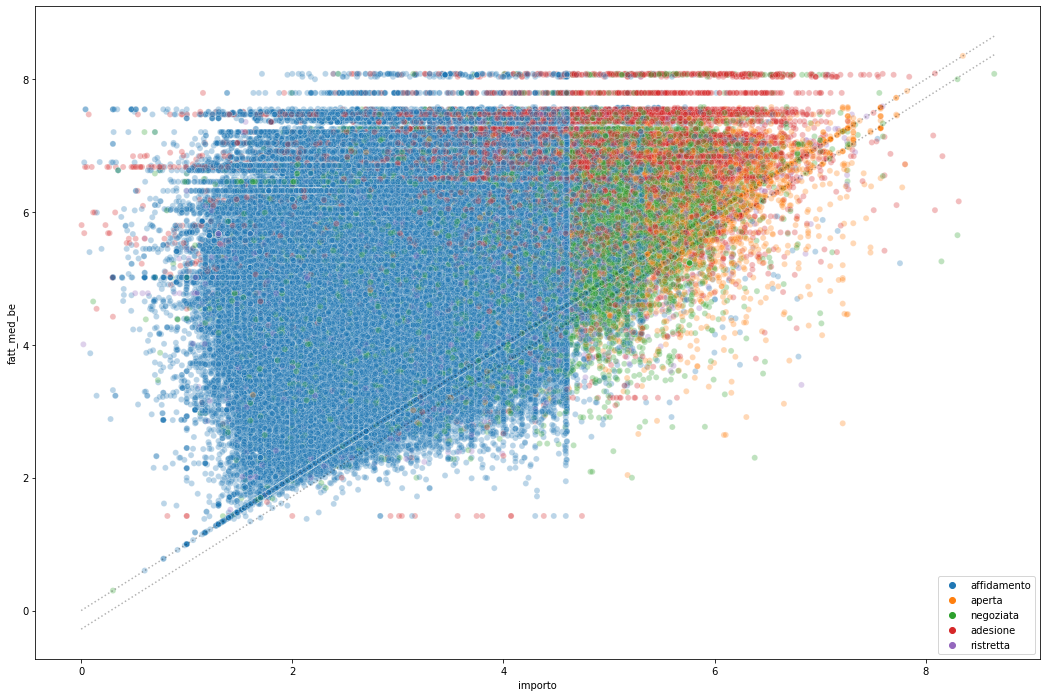

In [163]:
plt.figure(figsize=(6*3, 4*3))
sns.scatterplot(
    x=np.log10(df.importo)[np.log10(df.importo) > 0], 
    y=np.log10(df.fatt_med_be)[np.log10(df.importo) > 0],
    alpha=.3, hue=df.tipo_procedura
)

x = np.linspace(0, np.log10(df.importo).max())
# il fatturato dell'azienda coincide con l'importo di un singolo contratto
plt.plot(x, x, color='black', linestyle="dotted", alpha=.3) 
# x - .28 corrisponde a np.log10(df.importo - df.importo * (1 - 10^(-.28))), 
# dato che è fatturato mediano annuo, l'anno  
plt.plot(x, x - .28, color='black', linestyle="dotted", alpha=.3) 
plt.legend(loc="lower right")
plt.show()

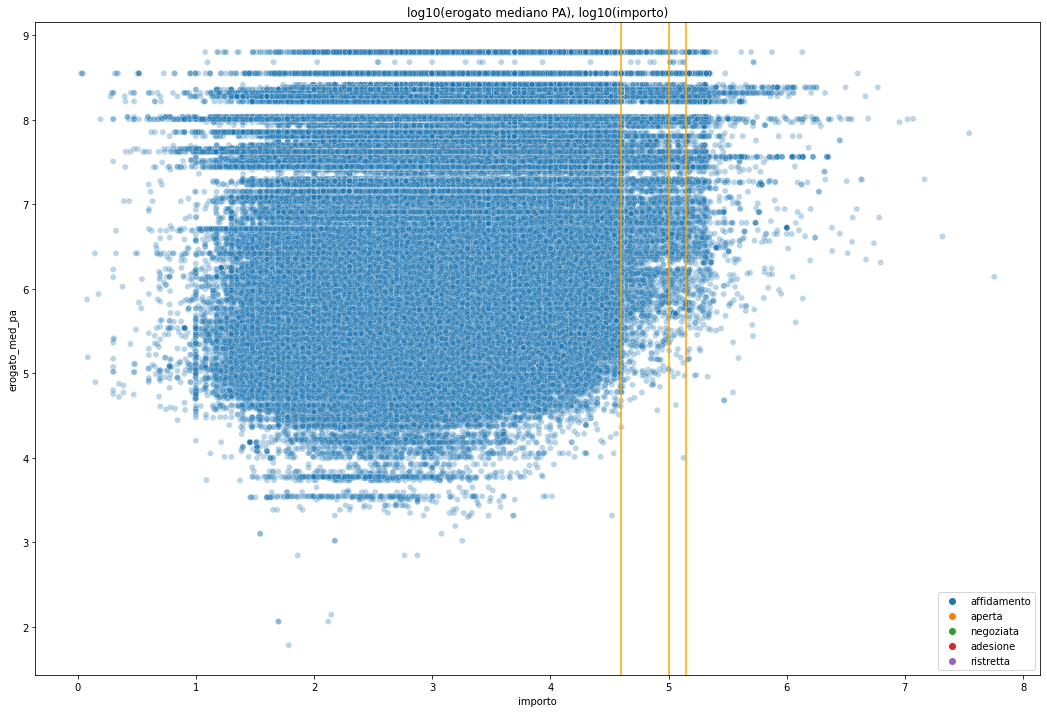

In [53]:
plt.figure(figsize=(6*3, 4*3))
sns.scatterplot(
    x=np.log10(df.importo)[np.log10(df.importo) > 0][df.tipo_procedura == "affidamento"], 
    y=np.log10(df.erogato_med_pa)[np.log10(df.importo) > 0],
    alpha=.3, hue=df.tipo_procedura
)
plt.axvline(np.log10(14e4), color='orange', linestyle="dotted", alpha=.3)
plt.axvline(np.log10(10e4), color='orange', linestyle="dotted", alpha=.3)
plt.axvline(np.log10(4e4), color='orange', linestyle="dotted", alpha=.3)
plt.legend(loc="lower right")
plt.title("log10(erogato mediano PA), log10(importo)")
plt.show()

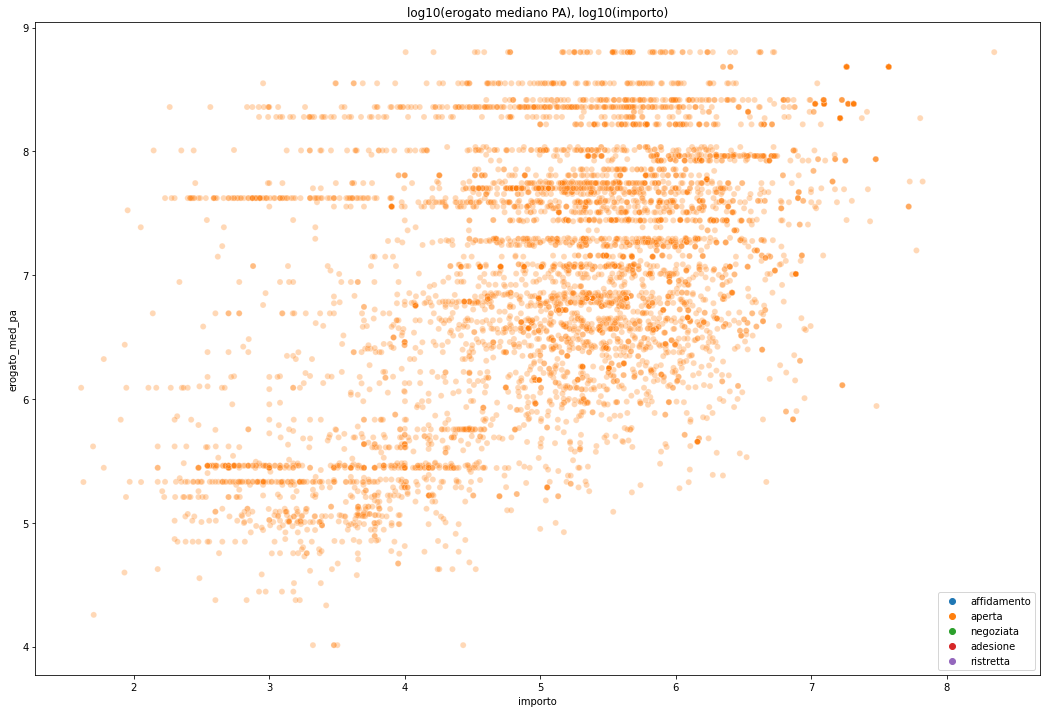

In [58]:
plt.figure(figsize=(6*3, 4*3))
sns.scatterplot(
    x=np.log10(df.importo)[np.log10(df.importo) > 0][df.tipo_procedura == "aperta"], 
    y=np.log10(df.erogato_med_pa)[np.log10(df.importo) > 0],
    alpha=.3, hue=df.tipo_procedura
)
plt.axvline(np.log10(14e4), color='black')
plt.axvline(np.log10(10e4), color='black')
plt.axvline(np.log10(4e4), color='black')
plt.legend(loc="lower right")
plt.title("log10(erogato mediano PA), log10(importo)")
plt.show()

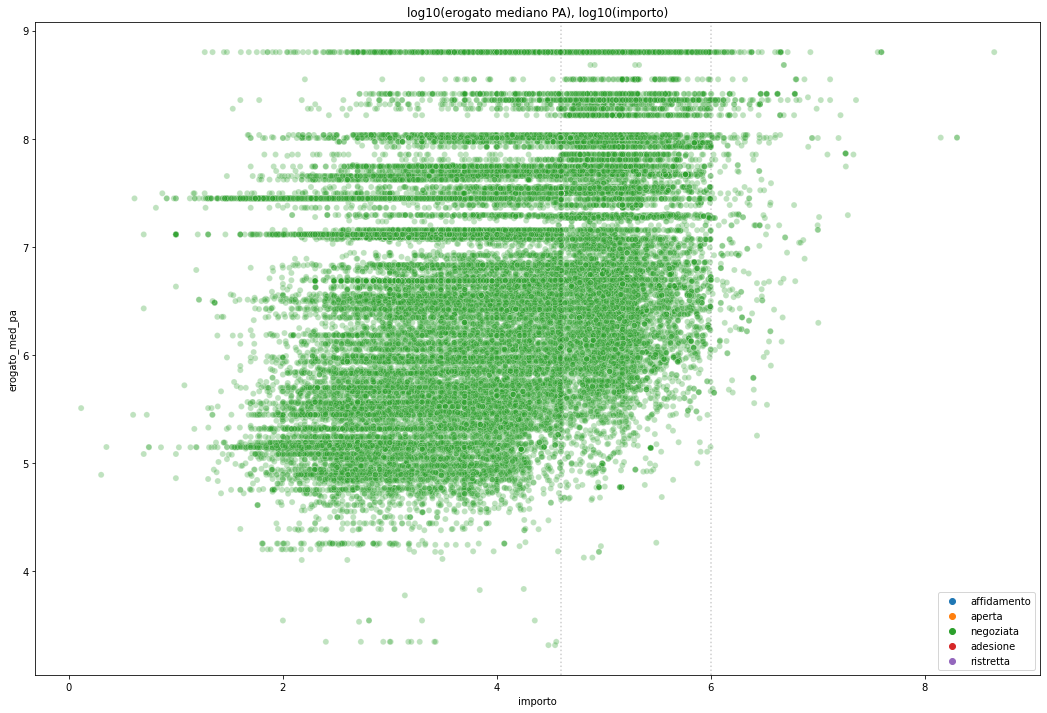

In [66]:
plt.figure(figsize=(6*3, 4*3))
sns.scatterplot(
    x=np.log10(df.importo)[np.log10(df.importo) > 0][df.tipo_procedura == "negoziata"], 
    y=np.log10(df.erogato_med_pa)[np.log10(df.importo) > 0],
    alpha=.3, hue=df.tipo_procedura
)
plt.axvline(np.log10(4e4), color='black', linestyle="dotted", alpha=.2)
plt.axvline(np.log10(1e6), color='black', linestyle="dotted", alpha=.2)
plt.legend(loc="lower right")
plt.title("log10(erogato mediano PA), log10(importo)")
plt.show()

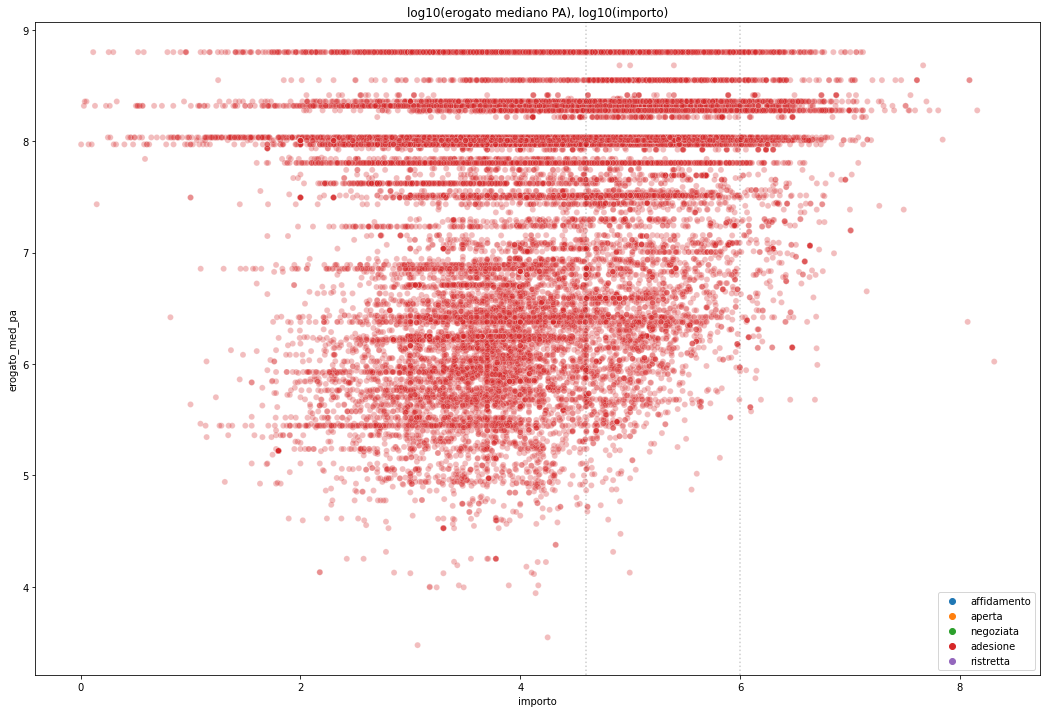

In [72]:
plt.figure(figsize=(6*3, 4*3))
sns.scatterplot(
    x=np.log10(df.importo)[np.log10(df.importo) > 0][df.tipo_procedura == "adesione"], 
    y=np.log10(df.erogato_med_pa)[np.log10(df.importo) > 0],
    alpha=.3, hue=df.tipo_procedura
)
plt.axvline(np.log10(4e4), color='black', linestyle="dotted", alpha=.2)
plt.axvline(np.log10(1e6), color='black', linestyle="dotted", alpha=.2)
plt.legend(loc="lower right")
plt.title("log10(erogato mediano PA), log10(importo)")
plt.show()

In [101]:
# top 5 cpv by occurrences
df.groupby("cpv").size().iloc[df.groupby('cpv').size().argsort()][::-1][:5]

cpv
33    88586
50    53837
30    44448
22    37652
45    32560
dtype: int64

* 33: apparecchiature mediche
* 50: servizi di riparazione e manutenzione
* 30: Macchine per ufficio ed elaboratori elettronici, attrezzature e forniture, esclusi i mobili e i pacchetti software

controllare per contratto mediano per fornitore. 

visualizzare le macro aree cpv

regole: contratti più alti del fatturato mediano e erogato mediano, sono sbagliati (controllare la soglia minima di contratti per azienda). visualizzare gli errati per tipo di procedura e uber_stazione 

# regole per l'eliminazione di outlier
1. contratti più grandi del valore mediano della pa e dell'azienda fornitrice aventi un numero minimo di contratti da valutare
2. togliamo via l'iva